- https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition#EDA
- https://www.kaggle.com/code/ekami66/detailed-exploratory-data-analysis-with-python
- https://www.kaggle.com/code/niteshx2/top-50-beginners-stacking-lgb-xgb/notebook
- https://www.kaggle.com/code/jesucristo/1-house-prices-solution-top-1/notebook#EDA
- https://www.kaggle.com/code/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda/report#header

In [455]:
import pandas as pd
import numpy as np
from scipy.stats import skew, boxcox_normmax, ttest_rel
from scipy.special import boxcox1p
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder, FunctionTransformer
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Ridge, Lasso, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

from functools import partial
from sklearn import ensemble, metrics, model_selection
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.pyll.base import scope
from timeit import default_timer as timer

pd.set_option('display.max_columns', None)
sns.set()

In [88]:
train=pd.read_csv('train.csv')

# EDA

In [89]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [90]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

`Alley` and `PoolQC` may be dropped. 

In [91]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Many right-skewed features, need to transform (log, box_cox, etc).

In [92]:
def miss_table(data):
    miss_table=data.isna().sum().to_frame(name='Count')
    miss_table['Percent']=miss_table['Count']/len(data)*100
    miss_table['Dtype']=data.dtypes[miss_table.index]
    miss_table['Count']=miss_table['Count'].replace({0: np.nan})
    miss_table=miss_table.dropna()
    print(f"There are {len(miss_table)}/{data.shape[1]} columns with missing values")
    print('Distribution by dtypes:')
    print(miss_table['Dtype'].value_counts())
    return miss_table.sort_values(by='Count', ascending=False)

mt=miss_table(train)
mt

There are 19/81 columns with missing values
Distribution by dtypes:
object     16
float64     3
Name: Dtype, dtype: int64


,Count,Percent,Dtype
PoolQC,1453.0,99.520548,object
MiscFeature,1406.0,96.301370,object
Alley,1369.0,93.767123,object
Fence,1179.0,80.753425,object
FireplaceQu,690.0,47.260274,object
LotFrontage,259.0,17.739726,float64
GarageType,81.0,5.547945,object
GarageYrBlt,81.0,5.547945,float64
GarageFinish,81.0,5.547945,object
GarageQual,81.0,5.547945,object


First 3-4 features may be dropped entirely, too much NaNs.

In [93]:
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [94]:
train.select_dtypes('object').nunique().sort_values(ascending=False)

Neighborhood     25
Exterior2nd      16
Exterior1st      15
SaleType          9
Condition1        9
Condition2        8
HouseStyle        8
RoofMatl          8
Functional        7
BsmtFinType2      6
Heating           6
RoofStyle         6
SaleCondition     6
BsmtFinType1      6
GarageType        6
Foundation        6
Electrical        5
FireplaceQu       5
HeatingQC         5
GarageQual        5
GarageCond        5
MSZoning          5
LotConfig         5
ExterCond         5
BldgType          5
BsmtExposure      4
MiscFeature       4
Fence             4
LotShape          4
LandContour       4
BsmtCond          4
KitchenQual       4
MasVnrType        4
ExterQual         4
BsmtQual          4
LandSlope         3
GarageFinish      3
PavedDrive        3
PoolQC            3
Utilities         2
CentralAir        2
Street            2
Alley             2
dtype: int64

`Neighborhood`, `Exterior2nd`, `Exterior1st` have highest cardinality out there. Not that much actually, OHE can be used.

mean=180921.196
std=79442.503
skewness=1.883
kurtosis=6.536


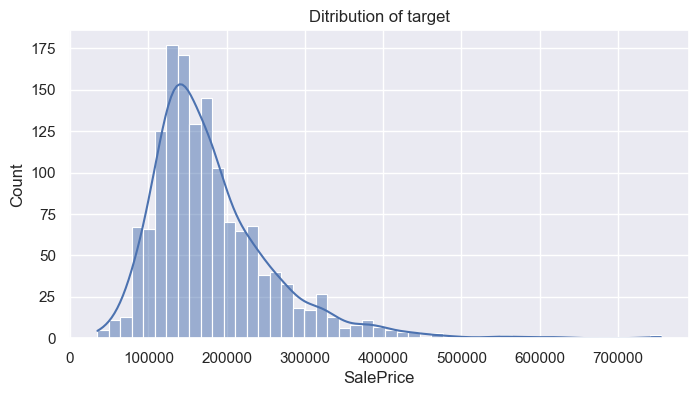

In [95]:
info=f'''mean={train["SalePrice"].mean():.3f}
std={train["SalePrice"].std():.3f}
skewness={train["SalePrice"].skew():.3f}
kurtosis={train["SalePrice"].kurt():.3f}'''
print(info)

fig, axes=plt.subplots(figsize=(8,4))
sns.histplot(train['SalePrice'], kde=True, ax=axes);
plt.title('Ditribution of target')
plt.show()

Right-skewed (some very high-price houses), high kurtosis (fat tails, some outliers). Need to transform, may help with performance.

In [96]:
def num_plot(data, pl_type='scatter'):
    nums=data.drop('Id', axis=1).select_dtypes(['number']).columns
    fig, axs = plt.subplots(int(np.round(len(list(data[nums]))/3)), 3, figsize=(12, 60))
    plt.subplots_adjust(right=1.5)
    plt.subplots_adjust(top=1.5)
    for i, feature in enumerate(list(data[nums])):
#         if(feature=='SalePrice'):
#             break
        if pl_type=='scatter':
            sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', palette='Reds', data=data, ax=axs[i//3, i%3])
        else:
            sns.histplot(x=feature, data=data, kde=True, ax=axs[i//3, i%3])


        plt.xlabel('{}'.format(feature), size=15, labelpad=1.5)
        plt.ylabel('SalePrice', size=15, labelpad=12.5)

        for j in range(2):
            plt.tick_params(axis='x', labelsize=12)
            plt.tick_params(axis='y', labelsize=12)

    plt.show()
    
# num_plot(train)

Eye-balled some outliers there, will remove them later.

In [97]:
# num_plot(train, 'hist')

In [98]:
def cat_plot(data, pl_type='box'):
    cats=train.select_dtypes(['object', 'category']).columns
    fig, axs = plt.subplots(int(np.ceil(len(list(data[cats]))/3)), 3, figsize=(12, 30))
    plt.subplots_adjust(right=1.5)
    plt.subplots_adjust(top=3)
    for i, feature in enumerate(list(data[cats])):
        if(feature=='SalePrice'):
            break
        if pl_type=='box':
            sns.boxplot(x=feature, y="SalePrice", data=data, ax=axs[i//3, i%3])
            axs[i//3, i%3].set_xticks(range(len(data[feature].dropna().unique())), 
                                      data[feature].dropna().unique(), rotation=45, ha='right')
        else:
            val_c=data[feature].value_counts().to_frame()
            sns.barplot(x=feature, y=val_c.index, data=val_c, ax=axs[i//3, i%3])


        plt.xlabel('{}'.format(feature), size=15, labelpad=1.5)
        plt.ylabel('SalePrice', size=15, labelpad=12.5)

        for j in range(2):
            plt.tick_params(axis='x', labelsize=12)
            plt.tick_params(axis='y', labelsize=12)

    plt.show()
    
# cat_plot(train)

In [99]:
# cat_plot(train, 'bar')

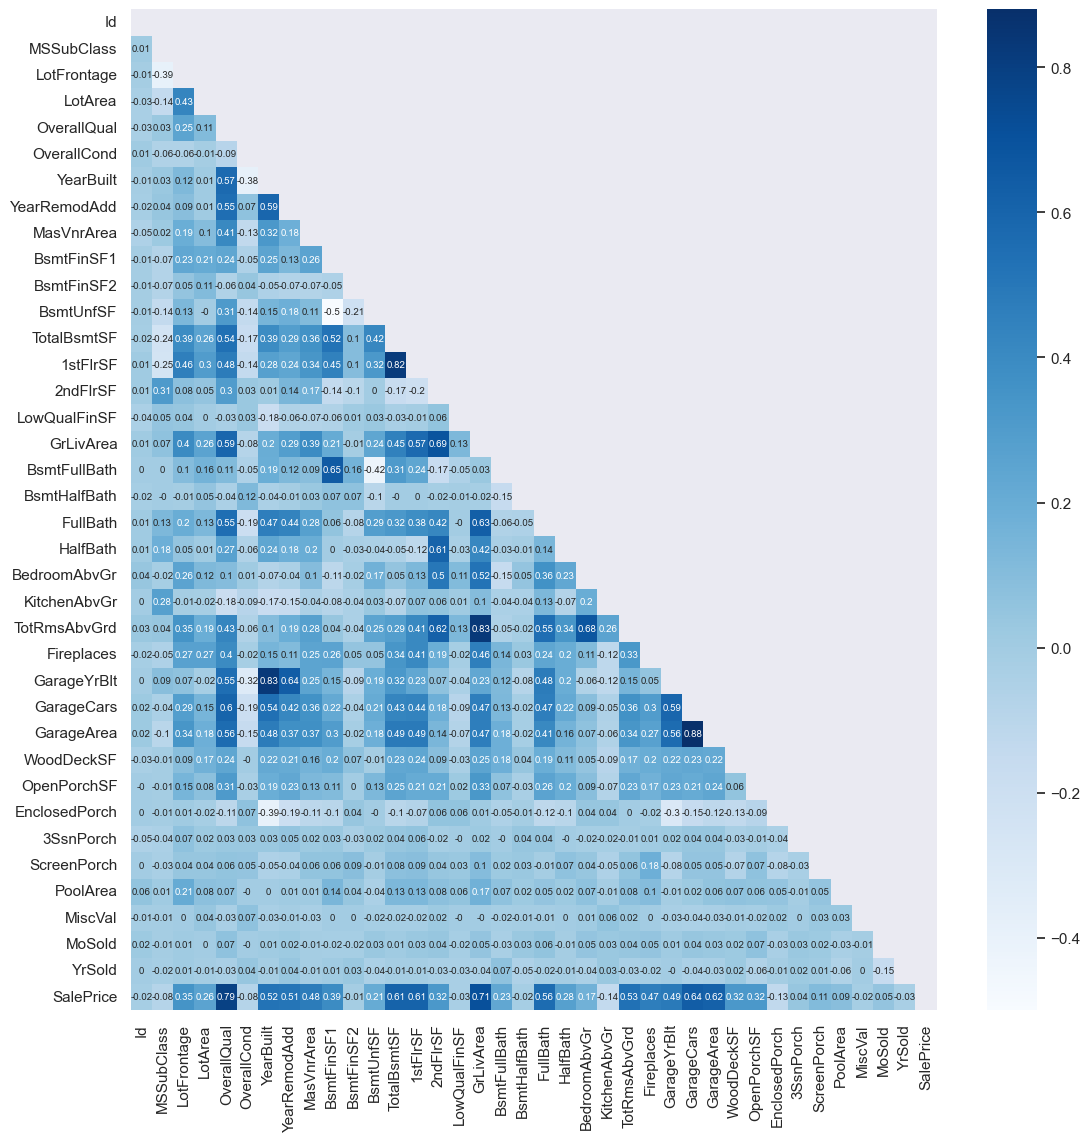

In [100]:
corr=train.corr()
mask=np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)]=True

plt.subplots(figsize=(13,13))
sns.heatmap(round(corr,2),
    cmap="Blues", mask=mask, annot=True, annot_kws={"size": 7});

There are some highly correlated variables (e.g., `GarageCars` and `GarageArea`). Should keep one of them.

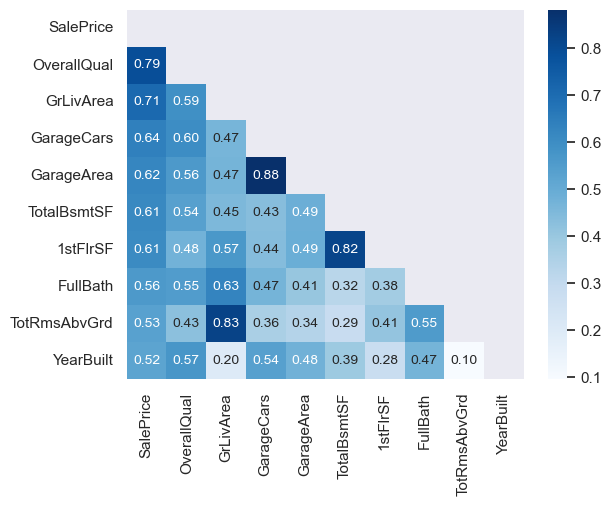

In [101]:
k=10
top_corrs=corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm=np.corrcoef(train[top_corrs].values.T)

mask=np.zeros_like(cm, dtype=bool)
mask[np.triu_indices_from(mask)]=True

# sns.set(font_scale=1.25)
hm=sns.heatmap(cm, cbar=True, annot=True, fmt='.2f', cmap="Blues", 
                annot_kws={'size': 10}, yticklabels=top_corrs.values, xticklabels=top_corrs.values,
                mask=mask)
plt.show()

# Data Preprocessing

In [102]:
def drop_outliers(frame, drop_certain=False):
    to_drop=[]
    data=frame.copy()
    print(f'Shape before dropping outliers: {data.shape}')
    to_drop.append(data[data['SalePrice']>700000].index.values)
    to_drop.append(data[data['LotFrontage']>300].index.values)
    to_drop.append(data[data['LotArea']>150000].index.values)
    to_drop.append(data[(data['YearBuilt']<1900) & (data['SalePrice']>200000)].index.values)
    to_drop.append(data[data['MasVnrArea']>1400].index.values)
    to_drop.append(data[(data['BsmtFinSF2']>400) & (data['BsmtFinSF2']<600) & (data['SalePrice']>500000)].index.values)
    to_drop.append(data[data['1stFlrSF']>4000].index.values)
    to_drop.append(data[data['GrLivArea']>4000].index.values)
    to_drop.append(data[(data['GarageArea']>1200) & (data['SalePrice']<300000)].index.values)
    to_drop.append(data[data['OpenPorchSF']>400].index.values)
    to_drop.append(data[data['MiscVal']>8000].index.values)
    
    if drop_certain:
        to_drop=set(np.concatenate(to_drop).ravel()).union(set([30, 88, 462, 631, 1322]))
#     print(sorted(to_drop))
    data=data.drop(to_drop)
    
    print(f'{len(to_drop)} samples are dropped')
    print(f'Shape after dropping outliers: {data.shape}')
    return data

In [103]:
train=drop_outliers(train, True)

Shape before dropping outliers: (1460, 81)
27 samples are dropped
Shape after dropping outliers: (1433, 81)


In [104]:
def drop_cols(frame, to_drop):
    data=frame.copy().drop(to_drop, axis=1)
    print(f'Shape after dropping columns: {data.shape}')
    return data

In [105]:
td=['Utilities', 'Street', 'PoolQC']
train=drop_cols(train, td)

Shape after dropping columns: (1433, 78)


In [106]:
def change_dtypes(frame):
    data=frame.copy()
    data['MSSubClass']=data['MSSubClass'].apply(str)
    data['YrSold']=data['YrSold'].apply(str)
    data['MoSold']=data['MoSold'].apply(str)
    return data

In [107]:
train=change_dtypes(train)

In [108]:
def handle_missing(frame):
    data=frame.copy()
    print(f'No of missing before: {data.isna().sum().sum()}')
    data['Functional']=data['Functional'].fillna('Typ')
    data['Electrical']=data['Electrical'].fillna("SBrkr")
    data['KitchenQual']=data['KitchenQual'].fillna("TA")
    data['Exterior1st']=data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
    data['Exterior2nd']=data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])
    data['SaleType']=data['SaleType'].fillna(data['SaleType'].mode()[0])    
    
    for c in data.select_dtypes('object').columns:
        data[c]=data.loc[:, c].fillna('None')
        
    data['LotFrontage']=data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    data['GarageYrBlt']=data['GarageYrBlt'].transform(lambda x: x.fillna(data['YearBuilt'].median()))
    
    for n in data.select_dtypes('number').columns:
        data[n]=data.loc[:, n].fillna(0)
    
    print(f'No of missing after: {data.isna().sum().sum()}')
    return data

In [109]:
train=handle_missing(train)

No of missing before: 5428
No of missing after: 0


In [110]:
def manual_encoder(frame):
    data=frame.copy()
    qual_map={'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
    bsmt_exp_map={'Gd':4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
    bsmt_fin_type_map={'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
    functional_map={'Typ':8, 'Min1':7, 'Maj1':6, 'Min2':5, 'Mod':4, 'Maj2':3, 'Sev':2, 'Sal':1, 'None':0}
    garage_finish_map={'Fin': 3, 'RFn': 2, 'Unf': 1, 'None':  0}
    paved_map={'Y': 3, 'P': 2, 'N': 1, 'None': 0}
#     lot_shape_map={'None':0, 'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4}
#     mansory_vnr_map={'None':0, 'BrkCmn':0, 'BrkFace':1, 'Stone':2}
    
    data['ExterQual']=data['ExterQual'].replace(qual_map)
    data['ExterCond']=data['ExterCond'].replace(qual_map)
    data['BsmtQual']=data['BsmtQual'].replace(qual_map)
    data['BsmtCond']=data['BsmtCond'].replace(qual_map)
    data['BsmtExposure']=data['BsmtExposure'].replace(bsmt_exp_map)
    data['BsmtFinType1']=data['BsmtFinType1'].replace(bsmt_fin_type_map)
    data['BsmtFinType2']=data['BsmtFinType2'].replace(bsmt_fin_type_map)
    data['HeatingQC']=data['HeatingQC'].replace(qual_map)
    data['KitchenQual']=data['KitchenQual'].replace(qual_map)
    data['Functional']=data['Functional'].replace(functional_map)
    data['FireplaceQu']=data['FireplaceQu'].replace(qual_map)
    data['GarageFinish']=data['GarageFinish'].replace(garage_finish_map)
    data['GarageQual']=data['GarageQual'].replace(qual_map)
    data['GarageCond']=data['GarageCond'].replace(qual_map)
    data['PavedDrive']=data['PavedDrive'].replace(paved_map)
#     data['LotShape']=data['LotShape'].replace(lot_shape_map)
#     data['MasVnrType']=data['MasVnrType'].replace(mansory_vnr_map)


    return data

In [111]:
train=manual_encoder(train)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,PConc,4,3,1,6,706,1,0,150,856,GasA,5,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,4,8,8,0,0,Attchd,2003.0,2,2,548,3,3,3,0,61,0,0,0,0,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,CBlock,4,3,4,5,978,1,0,284,1262,GasA,5,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,3,6,8,1,3,Attchd,1976.0,2,2,460,3,3,3,298,0,0,0,0,0,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,PConc,4,3,2,6,486,1,0,434,920,GasA,5,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,4,6,8,1,3,Attchd,2001.0,2,2,608,3,3,3,0,42,0,0,0,0,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,BrkTil,3,4,1,5,216,1,0,540,756,GasA,4,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,4,7,8,1,4,Detchd,1998.0,1,3,642,3,3,3,0,35,272,0,0,0,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,PConc,4,3,3,6,655,1,0,490,1145,GasA,5,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,4,9,8,1,3,Attchd,2000.0,2,3,836,3,3,3,192,84,0,0,0,0,None,None,0,12,2008,WD,Normal,250000


In [112]:
def reshift_target(frame, target):
    data=frame.copy()
    data[target]=np.log1p(data[target])
    return data

In [113]:
train=reshift_target(train, 'SalePrice')

mean=12.020
std=0.389
skewness=0.128
kurtosis=0.528


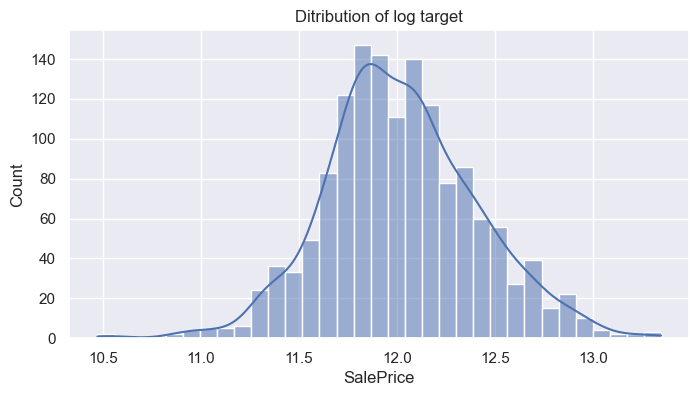

In [114]:
info=f'''mean={train["SalePrice"].mean():.3f}
std={train["SalePrice"].std():.3f}
skewness={train["SalePrice"].skew():.3f}
kurtosis={train["SalePrice"].kurt():.3f}'''
print(info)

fig, axes=plt.subplots(figsize=(8,4))
sns.histplot(train['SalePrice'], kde=True, ax=axes);
plt.title('Ditribution of log target');

# Feature Engineering

The dataset itself is not that much complicated, only around 15-20 features are added in a single function.

In [115]:
def generate_features(frame):
    data=frame.copy()
    print(f'Shape before adding features: {data.shape}')
    
    data['FullOverall']=data['OverallQual']+data['OverallCond']
    data['Condition1_2']=data['Condition1']+'_'+data['Condition2']
    data['YearBuildYearRemodDiff']=data['YearRemodAdd']-data['YearBuilt']
    data['IsRemod']=(data['YearRemodAdd']==data['YearBuilt']).astype(int)
    data['Exterior1st_2nd']=data['Exterior1st']+'_'+data['Exterior2nd']
    data['FullExter']=data['ExterQual']+data['ExterCond']
    data['FullBsmt']=data['BsmtQual']+data['BsmtCond']
    data['FullGarage']=data['GarageQual']+data['GarageCond']
    data['FullBsmtFinType']=data['BsmtFinType1']+data['BsmtFinType2']
    data['TotalSF']=data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
    data['TotalScoreAll']=(data['FullOverall']+data['FullExter']+data['FullBsmt']+data['FullGarage']
                            +data['KitchenQual']+data['FireplaceQu']+data['HeatingQC'])
    data['Total_Bathrooms']=(data['FullBath'] + (0.5 * data['HalfBath']) +
                                   data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))
    data['Total_porch_sf']=(data['OpenPorchSF'] + data['3SsnPorch'] +
                                  data['EnclosedPorch'] + data['ScreenPorch'] +
                                  data['WoodDeckSF'])
#     data['UnfBsmtRatio']=data['BsmtUnfSF']/data['TotalBsmtSF']
#     data['BsmtRatio']=data['TotalBsmtSF']/data['TotalSF']
    
    data['haspool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    data['has2ndfloor'] = data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    data['hasgarage'] = data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    data['hasbsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    data['hasfireplace'] = data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
#     aa=data.groupby('Neighborhood')['TotalSF'].mean().to_dict()
#     aa['None']=data['TotalSF'].mean()
#     data['SF_by_neigh']=data['TotalSF']/data['Neighborhood'].map(aa)
    print(f'Shape after adding features: {data.shape}')
    return data

In [116]:
train=generate_features(train)

Shape before adding features: (1433, 78)
Shape after adding features: (1433, 96)


I'll reskew highly skewed features using Box-Cox for all models except LGBM. I'll need to find and save lambdas beforehand, as I found `boxcox_normmax` must find optimal lambda on all data. Otherwise, it'll be very unstable.

In [161]:
lambda_dict={}
num_cols=train.drop(['Id', 'SalePrice'], axis=1).select_dtypes('number').columns
skew_cols=train[num_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew_cols=skew_cols[skew_cols>0.5].index

for i in high_skew_cols:
    lambda_dict[i]=boxcox_normmax(train[i]+1)
    
lambda_dict

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4427: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4464: NearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(stats.NearConstantInputWarning(msg))


{'PoolArea': 0.464989056825285,
 'haspool': 8.472135811722177,
 'MiscVal': 0.09465827540148551,
 '3SsnPorch': 0.034188282383871844,
 'LowQualFinSF': -0.10277897848940573,
 'LotArea': 0.14434637908574435,
 'KitchenAbvGr': 0.09894797128001599,
 'BsmtFinSF2': 0.1750258757867643,
 'BsmtHalfBath': -0.05699228865125184,
 'ScreenPorch': 0.4510736573337759,
 'BsmtFinType2': -0.41798656238002946,
 'EnclosedPorch': 0.36411056003522685,
 'MasVnrArea': 0.432434396395989,
 'YearBuildYearRemodDiff': -0.520562272190299,
 'OpenPorchSF': 0.4877627368155401,
 'WoodDeckSF': 0.6583067076041301,
 'ExterCond': 0.6154671946983415,
 'BsmtExposure': -0.13303781470815496,
 'Total_porch_sf': 0.653103125922187,
 'BsmtUnfSF': 0.5848503242957773,
 '1stFlrSF': 0.00925300782071509,
 'ExterQual': -0.0452078361258209,
 'GrLivArea': 0.1531873132464953,
 '2ndFlrSF': 1.1344385774744121,
 'BsmtFinSF1': 0.7650859732202838,
 'OverallCond': 0.545784586840111,
 'HalfBath': 1.1933275313959224,
 'TotRmsAbvGrd': 0.169568744271908

In [162]:
def deskew_col(frame, lambda_dict):
    data=frame.copy()
    for i in lambda_dict.keys():
        data[i]=boxcox1p(data[i], lambda_dict[i])
    return data

In [286]:
train=deskew_col(train, lambda_dict)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,FullOverall,Condition1_2,YearBuildYearRemodDiff,IsRemod,Exterior1st_2nd,FullExter,FullBsmt,FullGarage,FullBsmtFinType,TotalSF,TotalScoreAll,Total_Bathrooms,Total_porch_sf,haspool,has2ndfloor,hasgarage,hasbsmt,hasfireplace
0,1,60,RL,25.531527,18.624465,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.039488,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.401106,1.552282,2.188889,PConc,4,3,0.662148,6,196.545021,0.601769,0.0,30.451242,856,GasA,5,Y,SBrkr,6.968913,1867.022204,0.0,13.892719,0.995815,0.000000,2,1.078326,3,0.71747,4,2.662492,8,0.0000,0,Attchd,2003.0,2,2,548,3,3,3,0.000000,13.297875,0.000000,0.0,0.0,0.0,None,None,0.0,2,2008,WD,Normal,12.247699,12,Norm_Norm,0.000000,1,VinylSd_VinylSd,7,7,6,7,75.848001,41,3.5,21.148420,0.0,1,1,1,0
1,2,20,RL,29.697688,19.099397,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,4.246180,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,1.343747,2.188889,CBlock,4,3,1.448801,5,252.495312,0.601769,0.0,44.920876,1262,GasA,5,Y,SBrkr,7.382469,0.000000,0.0,12.964782,0.000000,0.679635,2,0.000000,3,0.71747,3,2.305379,8,0.9241,3,Attchd,1976.0,2,2,460,3,3,3,63.243312,0.000000,0.000000,0.0,0.0,0.0,None,None,0.0,5,2007,WD,Normal,12.109016,14,Feedr_Norm,0.000000,1,MetalSd_MetalSd,6,7,6,6,75.264842,44,2.5,61.839304,0.0,0,1,1,1
2,3,60,RL,26.385645,19.702079,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,3.039488,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,18.614453,1.552282,2.188889,PConc,4,3,1.022100,6,147.451005,0.601769,0.0,58.004216,920,GasA,5,Y,SBrkr,7.045605,1896.790809,0.0,14.029124,0.995815,0.000000,2,1.078326,3,0.71747,4,2.305379,8,0.9241,3,Attchd,2001.0,2,2,608,3,3,3,0.000000,10.788977,0.000000,0.0,0.0,0.0,None,None,0.0,9,2008,WD,Normal,12.317171,12,Norm_Norm,0.581871,0,VinylSd_VinylSd,7,7,6,7,77.755160,44,3.5,16.327209,0.0,1,1,1,1
3,4,70,RL,24.081723,19.079788,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,3.039488,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,1.343747,2.188889,BrkTil,3,4,0.662148,5,78.839045,0.601769,0.0,66.127151,756,GasA,4,Y,SBrkr,7.092008,1626.076902,0.0,13.905495,0.995815,0.000000,1,0.000000,3,0.71747,4,2.493229,8,0.9241,4,Detchd,1998.0,1,3,642,3,3,3,0.000000,9.723110,18.427404,0.0,0.0,0.0,None,None,0.0,2,2006,WD,Abnorml,11.849405,12,Norm_Norm,1.684687,0,Wd Sdng_Wd Shng,6,7,6,6,74.549562,43,2.0,63.078662,0.0,1,1,1,1
4,5,60,RL,30.768425,20.629136,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,3.039488,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,26.845536,1.552282,2.188889,PConc,4,3,1.265967,6,185.530168,0.601769,0.0,62.386784,1145,GasA,5,Y,SBrkr,7.278662,2367.469227,0.0,14.692940,0.995815,0.000000,2,1.078326,4,0.71747,4,2.816795,8,0.9241,3,Attchd,2000.0,2,3,836,3,3,3,47.028737,15.851348,0.000000,0.0,0.0,0.0,None,None,0.0,12,2008,WD,Normal,12.429220,13,Norm_Norm,0.000000,1,VinylSd_VinylSd,7,7,6,7,85.817896,45,3.5,58.753868,0.0,1,1,1,1


Now I'll put everything into a single feature pipeline, so one could get a model-ready feature set froma raw data by calling a single fit. Let's load the dataframe again and to test the pipeline

In [309]:
df=pd.read_csv('train.csv')

In [417]:
ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
for_regression=make_pipeline(FunctionTransformer(deskew_col, kw_args={'lambda_dict': lambda_dict}), RobustScaler())
for_lgbm='passthrough'

feature_pipe=Pipeline([
    ('drop_outliers', FunctionTransformer(drop_outliers, kw_args={'drop_certain': True}))
    ,('drop_columns', FunctionTransformer(drop_cols, kw_args={'to_drop': ['Utilities', 'Street', 'PoolQC']}))
    ,('change_dtypes', FunctionTransformer(change_dtypes))
    ,('handle_missing', FunctionTransformer(handle_missing))
    ,('manual_encoder', FunctionTransformer(manual_encoder))
    ,('reshift_target', FunctionTransformer(reshift_target,  kw_args={'target': 'SalePrice'}))
    ,('generate_features', FunctionTransformer(generate_features))
    ,('column_transformer', ColumnTransformer([
                            ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore'), make_column_selector(dtype_include=object))
                            ,()]))
])


# feature_pipe.named_steps['drop_outliers'].set_params(**{'kw_args':{'drop_certain': False}})
# Pipeline(feature_pipe.steps[1:])

In [418]:
df_reg=Pipeline(feature_pipe.steps[:-1]).fit_transform(df)
df_reg.shape

Shape before dropping outliers: (1460, 81)
27 samples are dropped
Shape after dropping outliers: (1433, 81)
Shape after dropping columns: (1433, 78)
No of missing before: 5428
No of missing after: 0
Shape before adding features: (1433, 78)
Shape after adding features: (1433, 96)


(1433, 96)

In [419]:
df_lgbm=Pipeline(feature_pipe.steps[:-1]).fit_transform(df)
df_lgbm.shape

Shape before dropping outliers: (1460, 81)
27 samples are dropped
Shape after dropping outliers: (1433, 81)
Shape after dropping columns: (1433, 78)
No of missing before: 5428
No of missing after: 0
Shape before adding features: (1433, 78)
Shape after adding features: (1433, 96)


(1433, 96)

# Modelling

## Ridge

In [443]:
def custom_sklearn_cv(data, k, model):
    metric_df=pd.DataFrame(columns=['Train rmse', 'Test rmse'])
    kfold=KFold(k)
    feature_pipe.named_steps['column_transformer'].transformers[1]=('num', for_regression, make_column_selector(dtype_include=np.number))
    features, target=data.drop(['Id', 'SalePrice'], axis=1), data['SalePrice']
    for f, (tr, te) in enumerate(kfold.split(features, y=target)):
        X_train, y_train=features.iloc[tr, :], target.iloc[tr]
        X_test, y_test=features.iloc[te, :], target.iloc[te]
        
        X_train_tr=feature_pipe.named_steps['column_transformer'].fit_transform(X_train)
        X_test_tr=feature_pipe.named_steps['column_transformer'].transform(X_test)

        mod=model
        mod.fit(X_train_tr, y_train)
        train_pred=mod.predict(X_train_tr)
        test_pred=mod.predict(X_test_tr)
        rmse_train=mean_squared_error(y_train, train_pred, squared=False)
        rmse_test=mean_squared_error(y_test, test_pred, squared=False)
        
        metric_df.loc[f]=[rmse_train, rmse_test]
        

    metric_df.loc['Avg']=[metric_df['Train rmse'].mean(), metric_df['Test rmse'].mean()]
    return metric_df, mod

In [449]:
alphas_alt=[14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]

res_ridge, model_ridge=custom_sklearn_cv(df_reg, 12, RidgeCV(alphas=alphas_alt, cv=10))
res_ridge

,Train rmse,Test rmse
0,0.091201,0.090363
1,0.091547,0.084827
2,0.091084,0.091744
3,0.089327,0.110868
4,0.090680,0.096552
5,0.087560,0.131537
6,0.090268,0.104679
7,0.088209,0.124133
8,0.091468,0.086758
9,0.090695,0.095471


In [259]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

In [260]:
ridge=make_pipeline(col_tr, RidgeCV(alphas=alphas_alt, cv=kfolds))
ridge_score=cv_rmse(ridge , X)
print("Ridge: {:.4f} ({:.4f})\n".format(ridge_score.mean(), ridge_score.std()))

Ridge: 0.1025 (0.0139)



## Lasso

In [450]:
alphas2=[5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

res_lasso, model_lasso =custom_sklearn_cv(df_reg, 12, LassoCV(max_iter=int(1e7), alphas=alphas2, random_state=42, cv=10))
res_lasso

,Train rmse,Test rmse
0,0.094105,0.089723
1,0.091548,0.084479
2,0.092414,0.094856
3,0.089453,0.109172
4,0.090471,0.098800
5,0.088741,0.136213
6,0.092144,0.100348
7,0.088449,0.121837
8,0.093058,0.086594
9,0.092073,0.095481


In [262]:
lasso=make_pipeline(col_tr, LassoCV(max_iter=int(1e7), alphas=alphas2, random_state=42, cv=kfolds))
lasso_score=cv_rmse(lasso , X)
print("LASSO: {:.4f} ({:.4f})\n".format(lasso_score.mean(), lasso_score.std()))

LASSO: 0.1022 (0.0143)



## ElasticNet

In [457]:
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

res_elastic, model_elastic=custom_sklearn_cv(df_reg, 12, ElasticNetCV(max_iter=int(1e7), alphas=e_alphas, cv=10, l1_ratio=e_l1ratio))
res_elastic

,Train rmse,Test rmse
0,0.093503,0.089391
1,0.092197,0.084939
2,0.091925,0.094652
3,0.088986,0.109656
4,0.091349,0.098556
5,0.088494,0.136129
6,0.091357,0.099979
7,0.088749,0.121859
8,0.092565,0.086065
9,0.091346,0.095271


## GradientBoostingRegressor

In [458]:
gbr=GradientBoostingRegressor(n_estimators=3000
                                ,learning_rate=0.05
                                ,max_depth=4
                                ,max_features='sqrt'
                                ,min_samples_leaf=15
                                ,min_samples_split=10
                                ,loss='huber'
                                ,random_state=42)  

In [459]:
res_gbr, model_gbr=custom_sklearn_cv(df_reg, 12, gbr)
res_gbr

,Train rmse,Test rmse
0,0.041349,0.099074
1,0.042867,0.087001
2,0.042397,0.085476
3,0.041961,0.110323
4,0.042592,0.108606
5,0.037296,0.144425
6,0.041883,0.099885
7,0.038994,0.132885
8,0.042027,0.080610
9,0.042554,0.097453


## XGBoost

In [463]:
xgboost = XGBRegressor(learning_rate=0.01
                       ,n_estimators=3460
                       ,max_depth=3
                       , min_child_weight=0
                       ,gamma=0
                       ,subsample=0.7
                       ,colsample_bytree=0.7
                       ,objective='reg:squarederror'
                       ,nthread=-1
                       ,scale_pos_weight=1
                       ,reg_alpha=0.00006)

In [465]:
res_xgb, model_xgb=custom_sklearn_cv(df_lgbm, 12, xgboost)
res_xgb

,Train rmse,Test rmse
0,0.045209,0.092911
1,0.045716,0.087266
2,0.045618,0.093575
3,0.045021,0.106666
4,0.045242,0.096122
5,0.043490,0.139079
6,0.045708,0.095411
7,0.044726,0.126875
8,0.045762,0.087688
9,0.045138,0.104306


## LGBM

In [431]:
import lightgbm as lgb

def custom_lgbm_cv(data, k):
    metric_df=pd.DataFrame(columns=['Train rmse', 'Test rmse'])
    kfold=KFold(k)
    feature_pipe.named_steps['column_transformer'].transformers[1]=('num', for_lgbm, make_column_selector(dtype_include=np.number))
    features, target=data.drop(['Id', 'SalePrice'], axis=1), data['SalePrice']
    for f, (tr, te) in enumerate(kfold.split(features, y=target)):
        X_train, y_train=features.iloc[tr, :], target.iloc[tr]
        X_test, y_test=features.iloc[te, :], target.iloc[te]
        
        X_train_tr=feature_pipe.named_steps['column_transformer'].fit_transform(X_train)
        X_test_tr=feature_pipe.named_steps['column_transformer'].transform(X_test)

        params=dict(objective='regression', 
                metrics='rmse',
                num_leaves=6,
                learning_rate=0.01, 
                n_estimators=7000,
                max_bin=200, 
                bagging_fraction=0.8,
                bagging_freq=4, 
                bagging_seed=8,
                feature_fraction=0.2,
                feature_fraction_seed=8,
                min_sum_hessian_in_leaf = 11,
                random_state=42,
                verbose=-1,)

        dtrain=lgb.Dataset(X_train_tr, label=y_train)
        dval=lgb.Dataset(X_test_tr, label=y_test)

        model=lgb.train(
                params=params,
                train_set=dtrain,
                valid_sets=[dtrain, dval],
                valid_names=['train', 'test'],
                callbacks=[lgb.early_stopping(10, verbose=-1), lgb.log_evaluation(-1)],
        # categorical_feature=a
        )
        
        test_score, train_score=model.best_score['test']['rmse'], model.best_score['train']['rmse']
        metric_df.loc[f]=[train_score, test_score]
        

    metric_df.loc['Avg']=[metric_df['Train rmse'].mean(), metric_df['Test rmse'].mean()]
    return metric_df, model

In [439]:
res_lgbm, model_lgbm=custom_lgbm_cv(df_lgbm, 12)

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[820]	train's rmse: 0.0913929	test's rmse: 0.0976711
Training until validation scores don't improve for 10 rounds


C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1021]	train's rmse: 0.0873171	test's rmse: 0.0970967
Training until validation scores don't improve for 10 rounds


C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[776]	train's rmse: 0.092525	test's rmse: 0.0981258
Training until validation scores don't improve for 10 rounds


C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[947]	train's rmse: 0.08745	test's rmse: 0.112394
Training until validation scores don't improve for 10 rounds


C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[899]	train's rmse: 0.0896005	test's rmse: 0.106764
Training until validation scores don't improve for 10 rounds


C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1224]	train's rmse: 0.0798347	test's rmse: 0.140206
Training until validation scores don't improve for 10 rounds


C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[811]	train's rmse: 0.0919206	test's rmse: 0.104677
Training until validation scores don't improve for 10 rounds


C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[856]	train's rmse: 0.0886144	test's rmse: 0.138444
Training until validation scores don't improve for 10 rounds


C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1180]	train's rmse: 0.0856595	test's rmse: 0.0899158
Training until validation scores don't improve for 10 rounds


C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[760]	train's rmse: 0.0929601	test's rmse: 0.100238
Training until validation scores don't improve for 10 rounds


C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[892]	train's rmse: 0.0887964	test's rmse: 0.109965
Training until validation scores don't improve for 10 rounds


C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[942]	train's rmse: 0.0881246	test's rmse: 0.111079


In [440]:
res_lgbm

,Train rmse,Test rmse
0,0.091393,0.097671
1,0.087317,0.097097
2,0.092525,0.098126
3,0.087450,0.112394
4,0.089601,0.106764
5,0.079835,0.140206
6,0.091921,0.104677
7,0.088614,0.138444
8,0.085660,0.089916
9,0.092960,0.100238


## Stacking

In [466]:
stack_gen=StackingCVRegressor(regressors=(model_ridge, 
                                          model_lasso, 
                                          model_elastic,
                                          model_gbr, 
                                          model_xgb, 
                                          model_lgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

## SVR

In [468]:
svr=SVR(C= 20, epsilon= 0.008, gamma=0.0003,)

In [469]:
res_svr, model_svr=custom_sklearn_cv(df_reg, 12, xgboost)
res_svr

,Train rmse,Test rmse
0,0.045209,0.092911
1,0.045716,0.087266
2,0.045618,0.093575
3,0.045021,0.106666
4,0.045242,0.096122
5,0.043490,0.139079
6,0.045708,0.095411
7,0.044726,0.126875
8,0.045762,0.087688
9,0.045138,0.104306


## Blending

In [476]:
feature_pipe.named_steps['column_transformer'].transformers[1]=('num', for_regression, make_column_selector(dtype_include=np.number))
df_reg=feature_pipe.fit_transform(df)

model_ridge.fit(df_reg.drop(['Id', 'SalePrice'], axis=1), df_reg['SalePrice'])
model_lasso.fit(df_reg.drop(['Id', 'SalePrice'], axis=1), df_reg['SalePrice'])
model_elastic.fit(df_reg.drop(['Id', 'SalePrice'], axis=1), df_reg['SalePrice'])
model_svr.fit(df_reg.drop(['Id', 'SalePrice'], axis=1), df_reg['SalePrice'])
stack_gen_model.fit(np.array(df_reg.drop(['Id', 'SalePrice'], axis=1)), df_reg['SalePrice'] )


feature_pipe.named_steps['column_transformer'].transformers[1]=('num', for_lgbm, make_column_selector(dtype_include=np.number))
df_lgbm=feature_pipe.fit_transform(df)
model_gbm.fit(df_lgbm.drop(['Id', 'SalePrice'], axis=1), df_reg['SalePrice'])
model_xgb.fit(df_lgbm.drop(['Id', 'SalePrice'], axis=1), df_reg['SalePrice']) 
model_lgbm.fit(df_lgbm.drop(['Id', 'SalePrice'], axis=1), df_reg['SalePrice'])

Shape before dropping outliers: (1460, 81)
27 samples are dropped
Shape after dropping outliers: (1433, 81)
Shape after dropping columns: (1433, 78)
No of missing before: 5428
No of missing after: 0
Shape before adding features: (1433, 78)
Shape after adding features: (1433, 96)


AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [470]:
def blend_models_predict(X):
    return ((0.1 * model_ridge.predict(X)) + \
            (0.05 * model_lasso.predict(X)) + \
            (0.1 * model_elastic.predict(X)) + \
            (0.1 * model_svr.predict(X)) + \
            (0.1 * model_gbm.predict(X)) + \
            (0.15 * model_xgb.predict(X)) + \
            (0.1 * model_lgbm.predict(X)) + \
            (0.3 * stack_gen_model.fit_predict(np.array(X))))

In [471]:
print(rmsle(y, blend_models_predict(df_reg)))

AttributeError: 'RidgeCV' object has no attribute 'fit_predict'

In [1374]:
# def_df.to_csv('default_accuracy.csv', index=False)

In [1375]:
def_df=pd.read_csv('default_accuracy.csv')
tstat=ttest_rel(def_df['Test rmse'].iloc[:12,], test_df['Test rmse'])

print(f'Default model: mean={def_df["Test rmse"].iloc[:12,].mean():.6f}, std={def_df["Test rmse"].iloc[:12,].std():.6f}')
print(f'Test model: mean={test_df["Test rmse"].mean():.6f}, std={test_df["Test rmse"].std():.6f}')
print(f't-statistic: {tstat.statistic}, pvalue: {tstat.pvalue}')

Default model: mean=0.113976, std=0.017334
Test model: mean=0.108764, std=0.015608
t-statistic: 2.1725844008559814, pvalue: 0.05253996909874439


# HPO

In [1376]:
cat_cols, num_cols=X.select_dtypes(include=['category', 'object']).columns, X.select_dtypes('number').columns

col_tr=ColumnTransformer([
    ('cat', ohe, cat_cols),
    ('num', 'passthrough', num_cols)
])

In [1462]:
def optimize(params, x, y, k=5):
    global ITERATION
    ITERATION += 1
    rmses_test=[]
    params['metrics']='rmse'
    params['verbose']=-1

    start = timer()
    kfold=KFold(k)
    for f, (tr, te) in enumerate(kfold.split(x, y=y)):
        X_train, y_train=x.iloc[tr, :], y.iloc[tr]
        X_test, y_test=x.iloc[te, :], y.iloc[te]
        
        X_train=col_tr.fit_transform(X_train)
        X_test=col_tr.transform(X_test)
        
        params=params
        dtrain=lgb.Dataset(X_train, label=y_train)
        dval=lgb.Dataset(X_test, label=y_test)
   
        model=lgb.train(
                params=params,
                train_set=dtrain,
                valid_sets=[dtrain, dval],
                valid_names=['train', 'test'],
                callbacks=[lgb.early_stopping(10, verbose=-100), lgb.log_evaluation(-100)],
#                 categorical_feature=a,
                verbose_eval=False)
        
        rmses_test.append(model.best_score['test']['rmse'])

    run_time = timer() - start
    
    rmse_mean=np.mean(rmses_test)
    return {'loss': rmse_mean, 
            'params': params, 
            'iteration': ITERATION,
            'train_time': run_time, 
            'status': STATUS_OK}

In [1463]:
t=Trials()

In [1464]:
X, y=train.drop(['Id', 'SalePrice'], axis=1), train['SalePrice']

param_space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 500, 5000, 50)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 4, 12, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'max_bin': scope.int(hp.quniform('max_bin', 150, 300, 5)),
    'feature_fraction': hp.uniform('feature_fraction', 0.1, 0.8),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.1, 0.8),
    'bagging_freq': scope.int(hp.quniform('bagging_freq', 2, 5, 1)),
}


ITERATION, MAX_EVALS=1, 500
t=Trials()
hopt=fmin(
    fn=partial(optimize, x=X, y=y),
    space=param_space,
    algo=tpe.suggest,
    max_evals=MAX_EVALS,
    trials=t
)

hopt

Training until validation scores don't improve for 10 rounds                                                           
Early stopping, best iteration is:                                                                                     
[94]	train's rmse: 0.0868105	test's rmse: 0.10211
Training until validation scores don't improve for 10 rounds                                                           
  0%|                                                                            | 0/3 [00:00<?, ?trial/s, best loss=?]

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM.

Early stopping, best iteration is:                                                                                     
[110]	train's rmse: 0.0817313	test's rmse: 0.112561
Training until validation scores don't improve for 10 rounds                                                           
Early stopping, best iteration is:                                                                                     
[157]	train's rmse: 0.0704812	test's rmse: 0.121961
  0%|                                                                            | 0/3 [00:00<?, ?trial/s, best loss=?]

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



Training until validation scores don't improve for 10 rounds                                                           
Early stopping, best iteration is:                                                                                     
[152]	train's rmse: 0.0750247	test's rmse: 0.113453
  0%|                                                                            | 0/3 [00:00<?, ?trial/s, best loss=?]

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM.

Training until validation scores don't improve for 10 rounds                                                           
Early stopping, best iteration is:                                                                                     
[96]	train's rmse: 0.0854151	test's rmse: 0.115448
Training until validation scores don't improve for 10 rounds                                                           
Early stopping, best iteration is:                                                                                     
[132]	train's rmse: 0.0914497	test's rmse: 0.102643
Training until validation scores don't improve for 10 rounds                                                           
 33%|████████████████▎                                | 1/3 [00:01<00:01,  1.20trial/s, best loss: 0.11310668732148058]

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM.

Early stopping, best iteration is:                                                                                     
[124]	train's rmse: 0.0922817	test's rmse: 0.109186
Training until validation scores don't improve for 10 rounds                                                           
Early stopping, best iteration is:                                                                                     
[186]	train's rmse: 0.0804076	test's rmse: 0.120855
 33%|████████████████▎                                | 1/3 [00:01<00:01,  1.20trial/s, best loss: 0.11310668732148058]

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM.

Training until validation scores don't improve for 10 rounds                                                           
Early stopping, best iteration is:                                                                                     
[132]	train's rmse: 0.091217	test's rmse: 0.111326
Training until validation scores don't improve for 10 rounds                                                           
Early stopping, best iteration is:                                                                                     
[136]	train's rmse: 0.0881124	test's rmse: 0.113872
Training until validation scores don't improve for 10 rounds                                                           
 67%|████████████████████████████████▋                | 2/3 [00:01<00:00,  1.22trial/s, best loss: 0.11157646609982992]

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM.

Early stopping, best iteration is:                                                                                     
[132]	train's rmse: 0.0859144	test's rmse: 0.101651
Training until validation scores don't improve for 10 rounds                                                           
Early stopping, best iteration is:                                                                                     
[164]	train's rmse: 0.0794527	test's rmse: 0.112115
Training until validation scores don't improve for 10 rounds                                                           
 67%|████████████████████████████████▋                | 2/3 [00:02<00:00,  1.22trial/s, best loss: 0.11157646609982992]

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM.

Early stopping, best iteration is:                                                                                     
[166]	train's rmse: 0.077149	test's rmse: 0.122167
Training until validation scores don't improve for 10 rounds                                                           
Early stopping, best iteration is:                                                                                     
[229]	train's rmse: 0.0727767	test's rmse: 0.106912
 67%|████████████████████████████████▋                | 2/3 [00:02<00:00,  1.22trial/s, best loss: 0.11157646609982992]

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

C:\Users\Akim.Alikhanov\Anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM.

Training until validation scores don't improve for 10 rounds                                                           
Early stopping, best iteration is:                                                                                     
[174]	train's rmse: 0.0773042	test's rmse: 0.113119
100%|██████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20trial/s, best loss: 0.1111927127396309]


{'bagging_fraction': 0.553976793371121,
 'bagging_freq': 2.0,
 'feature_fraction': 0.6519700989049169,
 'learning_rate': 0.05071015910308035,
 'max_bin': 270.0,
 'n_estimators': 2100.0,
 'num_leaves': 9.0}

In [1465]:
# {'bagging_fraction': 0.7795823481151618,
#  'bagging_freq': 5,
#  'metrics': 'rmse',
#  'feature_fraction': 0.10460611768839309,
#  'gdbt_subsample': 0.6722069322518277,
#  'learning_rate': 0.019688809797590835,
#  'max_bin': 300,
#  'n_estimators': 4300,
#  'num_leaves': 12}

In [1466]:
hpo_res=pd.DataFrame()
params_list=[exp['params'] for exp in t.results]

for i in ['iteration', 'loss']:
    hpo_res[i]=[exp[i] for exp in t.results]
    
for n, p in enumerate(params_list):
    for k,v in p.items():
        hpo_res.loc[n, k]=v
        
hpo_res.sort_values('loss').head(10)

,iteration,loss,bagging_fraction,bagging_freq,feature_fraction,learning_rate,max_bin,n_estimators,num_leaves,metrics,verbose
2,4,0.111193,0.553977,2.0,0.651970,0.050710,270.0,2100.0,9.0,rmse,-1.0
1,3,0.111576,0.798356,2.0,0.408588,0.074385,225.0,1950.0,5.0,rmse,-1.0
0,2,0.113107,0.506519,2.0,0.379791,0.068416,230.0,4400.0,11.0,rmse,-1.0


# Stuff

In [1380]:
# Test model: mean=0.108764, std=0.015608
# excluding my bsmt features and n_est=7000 params

In [1381]:
X, y=train.drop(['Id', 'SalePrice'], axis=1), train['SalePrice']

cat_cols, num_cols=X.select_dtypes(include=['category', 'object']).columns, X.select_dtypes('number').columns

ohe=OneHotEncoder(sparse=False, handle_unknown='ignore')
col_tr=ColumnTransformer([
    ('cat', ohe, cat_cols),
    ('num', 'passthrough', num_cols)
])

X_tr=col_tr.fit_transform(X)


lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )


kf = KFold(n_splits=12, random_state=42, shuffle=True)

def cv_rmse(model, X=X_tr):
    rmse = np.sqrt(-cross_val_score(model, X_tr, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

# score = cv_rmse(lightgbm)
# print("lightgbm: {:.6f} ({:.6f})".format(score.mean(), score.std()))